In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as  plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Flatten, Reshape

In [5]:
data = pd.read_csv("../../data/csv_files/at200.csv")

In [7]:
data.shape

(104852, 22)

In [9]:
data.head()

,Date Time,Actual Conductivity (ÂµS/cm),Specific Conductivity (ÂµS/cm),Salinity (psu),Resistivity (â„¦-cm),Density (g/cmÂ³),Total Dissolved Solids (mg/L),pH (pH),pH MV (mV),ORP (mV),...,Partial Pressure Oâ‚‚ (psi),Temperature (C),External Voltage (V),Pressure (psi),Depth (m),Level: Depth to Water (m),station_id,Level: Elevation (m),easting,northing
0,2023-01-11 14:34:00.000,161.135101,169.814270,0.089782,6205.972656,0.998789,110.379279,6.345863,33.323765,242.252640,...,1.728853,17.324095,15.786,1.576587,1.299949,2.264972,FPZ_04A,NaN,1383303.353,3875869.513
1,2023-01-11 14:39:00.000,161.549484,169.920212,0.089823,6190.053711,0.998772,110.448137,6.392928,30.763149,241.012863,...,1.653776,17.420801,15.813,1.575842,1.299401,2.177014,FPZ_04A,NaN,1383303.353,3875869.513
2,2023-01-12 00:00:00.000,160.563217,167.590134,0.088505,6228.076660,0.998702,108.933590,6.545794,22.439957,233.128357,...,1.121557,17.804754,15.777,1.577938,1.300915,2.175540,FPZ_04A,NaN,1383303.353,3875869.513
3,2023-01-13 00:00:00.000,160.465378,167.549561,0.088486,6231.874023,0.998705,108.907215,6.533609,23.105145,233.137894,...,1.053462,17.786329,15.804,1.586493,1.306872,2.169526,FPZ_04A,NaN,1383303.353,3875869.513
4,2023-01-14 00:00:00.000,160.041122,167.145935,0.088271,6248.394043,0.998707,108.644858,6.524963,23.577213,230.408005,...,1.064563,17.774521,15.786,1.592077,1.310799,2.165600,FPZ_04A,NaN,1383303.353,3875869.513


In [11]:
del(data["Level: Elevation (m)"])

In [13]:
station_data = data[data['station_id'] == "FSB_097D"]
station_data.shape

(9211, 21)

In [15]:
station_data = station_data.dropna()
station_data = station_data[1:]
station_data.shape

(3110, 21)

In [17]:
date_time = station_data["Date Time"]
input_data = station_data.drop(columns = ["pH (pH)", "Date Time", "station_id"])
output_data = station_data["pH (pH)"].values.reshape(-1,1)


input_scaler = StandardScaler()
output_scaler = StandardScaler()

scaled_input = input_scaler.fit_transform(input_data)
scaled_output = output_scaler.fit_transform(output_data)

scaled_input.shape, scaled_output.shape

((3110, 18), (3110, 1))

In [19]:
def create_3d_arrays_from_2d(array1, array2, overlap, window_size=10 ):
    def create_3d_array(array, window_size, overlap):
        step = window_size - overlap
        num_rows, num_columns = array.shape
        num_windows = (num_rows - window_size) // step + 1

        array_3d = np.zeros((num_windows, window_size, num_columns))
        
        count = 0
        for i in range(0, num_windows, step):
            array_3d[count] = array[i:i+window_size]
            count += 1
        
        return array_3d

    array1_3d = create_3d_array(array1, window_size, overlap)
    array2_3d = create_3d_array(array2, window_size, overlap)

    return array1_3d, array2_3d

In [21]:
X_train, Y_train = create_3d_arrays_from_2d(scaled_input, scaled_output, 6)

In [23]:
X_train.shape, Y_train.shape

((776, 10, 18), (776, 10, 1))

In [25]:
model = Sequential([
    Conv1D(32, kernel_size=3, activation='relu', input_shape=(10, 18)),
    MaxPooling1D(pool_size=2),
    
    Conv1D(64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    
    Flatten(),    
    Dense(64, activation='relu'),
    Dense(10, activation='linear')
])

model.compile(optimizer='adam', loss='mean_squared_error') 

/Users/sandeshgnawali/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [27]:
model.fit(X_train, Y_train, epochs = 100, batch_size = 64)

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step - loss: 0.4327
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 662us/step - loss: 0.1025
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step - loss: 0.0214
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step - loss: 0.0145
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 666us/step - loss: 0.0085
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step - loss: 0.0094
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step - loss: 0.0053
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 671us/step - loss: 0.0059
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0055
Epoch 10/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step - loss: 0.0049
Epoch 11/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step - loss: 0.0039
Epoch 12/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step - loss: 0.0043
Epoch 13/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step - loss: 0.0031
Epoch 14/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step - loss: 0.0029
Epoch 15/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 76

In [29]:
X_test, Y_test = create_3d_arrays_from_2d(scaled_input, scaled_output, 0)
X_test.shape, Y_test.shape

((311, 10, 18), (311, 10, 1))

In [31]:
model.evaluate(X_test, Y_test)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 523us/step - loss: 9.5995e-04


0.00035996510996483266

In [33]:
Y_pred = model.predict(X_test)
Y_pred.shape



10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


(311, 10)

In [35]:
y_pred = Y_pred.flatten()
y_test = Y_test.flatten()

y_pred.shape, y_test.shape

((3110,), (3110,))

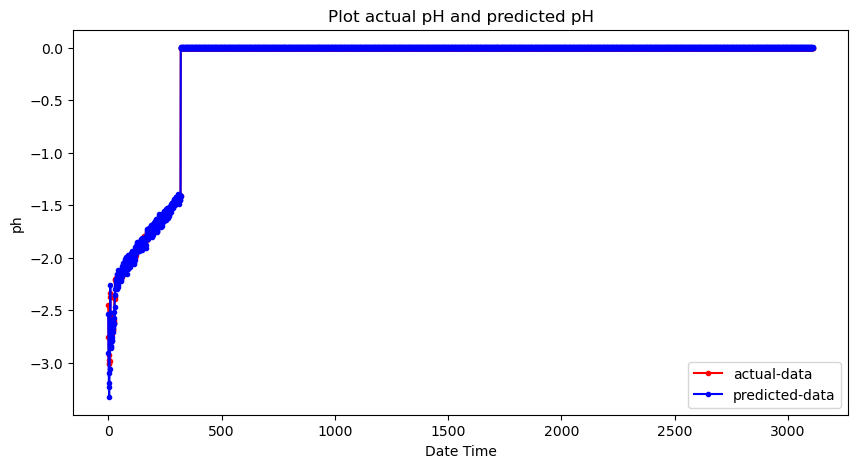

In [37]:
plt.figure(figsize=(10, 5))
index = 0
# for index in range(10):
plt.plot(y_test, marker='.', color="red", label="actual-data")
plt.plot(y_pred, marker='.', color="blue", label = "predicted-data")


plt.xlabel('Date Time')
plt.ylabel('ph')
plt.title(f'Plot actual pH and predicted pH')
plt.legend()
plt.show()